# HCI 前半レポート課題: 時間帯分類器

屋外風景画像から時間帯（day / night / sunrise_sunset）を推定する3クラス分類器を構築します。

## 目次
1. Setup（import / device）
2. Dataset split（raw→train/val/test）
3. DataLoader / transforms
4. Model definition
5. Training（train/val）
6. Test evaluation
7. Visualization（予測例・誤分類例）

## 1. Setup（import / device）

In [1]:
# 必要なライブラリのインストール（インストール済み）
# !pip install torch torchvision matplotlib scikit-learn tqdm pillow

In [2]:
import sys
import os
from pathlib import Path
import importlib

# プロジェクトルートをパスに追加
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root / "src"))

# 各種ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 自作モジュールのインポート（再読み込み対応）
import split_dataset
import train_eval_utils
importlib.reload(split_dataset)
importlib.reload(train_eval_utils)

from split_dataset import split_dataset, print_stats
from train_eval_utils import (
    create_dataloaders,
    create_model,
    train_model,
    evaluate_model,
    get_misclassified_samples_with_paths,
    plot_history,
    plot_confusion_matrix,
    plot_misclassified_examples,
    save_metrics,
    CLASS_NAMES,
)

# 乱数シードの設定（再現性確保）
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# パスの設定
DATA_DIR = project_root / "data"
RAW_DIR = DATA_DIR / "raw"
MODEL_DIR = project_root / "models"
OUTPUT_DIR = project_root / "outputs"

print(f"Project root: {project_root}")
print(f"Data directory: {DATA_DIR}")

Using device: cpu
Project root: /Users/HikaruUmada/Library/CloudStorage/OneDrive-筑波大学/授業 2025/ヒューマンコンピュータインタラクション/前半レポート課題
Data directory: /Users/HikaruUmada/Library/CloudStorage/OneDrive-筑波大学/授業 2025/ヒューマンコンピュータインタラクション/前半レポート課題/data


## 2. Dataset split（raw→train/val/test）

データセットを train 70% / val 15% / test 15% に分割します。
既に分割済みの場合はスキップされます。

In [3]:
# データセットの分割（既に分割済みの場合はスキップ）
stats = split_dataset(
    raw_dir=str(RAW_DIR),
    output_dir=str(DATA_DIR),
    train_ratio=0.7,
    val_ratio=0.15,
    seed=SEED,
    force=False  # Trueにすると既存の分割を上書き
)

print_stats(stats)

警告: /Users/HikaruUmada/Library/CloudStorage/OneDrive-筑波大学/授業 2025/ヒューマンコンピュータインタラクション/前半レポート課題/data/train は既に存在します。forceオプションで上書き可能です。

データセット分割結果

train: 1862 枚
  - day: 644 枚
  - night: 529 枚
  - sunrise_sunset: 689 枚

val: 398 枚
  - day: 138 枚
  - night: 113 枚
  - sunrise_sunset: 147 枚

test: 401 枚
  - day: 138 枚
  - night: 114 枚
  - sunrise_sunset: 149 枚


In [4]:
# 分割後のディレクトリ構造を確認
for split in ["train", "val", "test"]:
    split_dir = DATA_DIR / split
    if split_dir.exists():
        print(f"\n{split}/")
        for class_dir in sorted(split_dir.iterdir()):
            if class_dir.is_dir():
                n_images = len(list(class_dir.glob("*")))
                print(f"  {class_dir.name}/: {n_images} images")


train/
  day/: 644 images
  night/: 529 images
  sunrise_sunset/: 689 images

val/
  day/: 138 images
  night/: 113 images
  sunrise_sunset/: 147 images

test/
  day/: 138 images
  night/: 114 images
  sunrise_sunset/: 149 images


## 3. DataLoader / transforms

データ拡張とDataLoaderを設定します。

### Train用 transforms
- Resize(224, 224)
- RandomHorizontalFlip(p=0.5)
- RandomRotation(degrees=10)
- ToTensor()
- Normalize(ImageNet mean/std)

※時間帯分類のため、ColorJitter等の色味・明るさ変更はOFF

### Val/Test用 transforms
- Resize(224, 224)
- ToTensor()
- Normalize(ImageNet mean/std)

In [5]:
# ハイパーパラメータの設定
BATCH_SIZE = 32  # CPUの場合は16に減らしてもOK
IMAGE_SIZE = 224
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_CLASSES = 3

print(f"Batch size: {BATCH_SIZE}")
print(f"Image size: {IMAGE_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")

Batch size: 32
Image size: 224
Epochs: 10
Learning rate: 0.0001


In [6]:
# DataLoaderの作成
train_loader, val_loader, test_loader, class_names = create_dataloaders(
    data_dir=str(DATA_DIR),
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    num_workers=0  # macOSの場合は0が安定
)

print(f"Class names: {class_names}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Class names: ['day', 'night', 'sunrise_sunset']
Train batches: 59
Val batches: 13
Test batches: 13


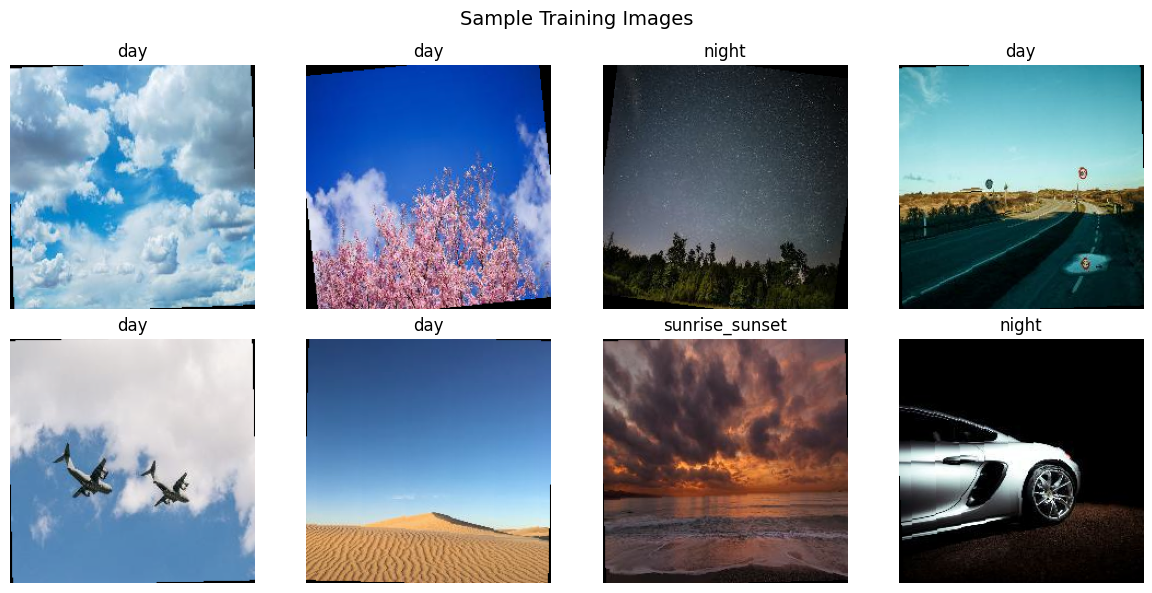

In [7]:
# サンプル画像の確認
def show_sample_images(dataloader, class_names, n_samples=8):
    """サンプル画像を表示する"""
    images, labels = next(iter(dataloader))
    
    # 正規化を解除
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(min(n_samples, len(images))):
        img = images[i].numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis("off")
    
    plt.suptitle("Sample Training Images", fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_images(train_loader, class_names)

## 4. Model definition

ResNet18（ImageNet事前学習済み）をベースに、最終全結合層を3クラス出力に置換します。

In [8]:
# モデルの作成
model = create_model(num_classes=NUM_CLASSES, pretrained=True)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# モデルのパラメータ数を確認
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 11,178,051
Trainable parameters: 11,178,051


## 5. Training（train/val）

モデルを学習します。

- 損失関数: CrossEntropyLoss
- Optimizer: Adam
- 学習率: 1e-4
- val accuracy が最高のモデルを `models/best_model.pt` に保存

In [10]:
# 損失関数とオプティマイザの設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# モデルの保存パス
model_save_path = str(MODEL_DIR / "best_model.pt")
print(f"Best model will be saved to: {model_save_path}")

Best model will be saved to: /Users/HikaruUmada/Library/CloudStorage/OneDrive-筑波大学/授業 2025/ヒューマンコンピュータインタラクション/前半レポート課題/models/best_model.pt


In [11]:
# 学習の実行
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path=model_save_path
)


Epoch 1/10
----------------------------------------


Train Loss: 0.3087, Train Acc: 0.8883
Val Loss: 0.2195, Val Acc: 0.9246
Best model saved (val_acc: 0.9246)

Epoch 2/10
----------------------------------------


Train Loss: 0.1531, Train Acc: 0.9447
Val Loss: 0.2911, Val Acc: 0.9070

Epoch 3/10
----------------------------------------


Train Loss: 0.1023, Train Acc: 0.9699
Val Loss: 0.2250, Val Acc: 0.9221

Epoch 4/10
----------------------------------------


Train Loss: 0.0577, Train Acc: 0.9850
Val Loss: 0.2380, Val Acc: 0.9347
Best model saved (val_acc: 0.9347)

Epoch 5/10
----------------------------------------


Train Loss: 0.0518, Train Acc: 0.9855
Val Loss: 0.2640, Val Acc: 0.9271

Epoch 6/10
----------------------------------------


Train Loss: 0.0521, Train Acc: 0.9828
Val Loss: 0.2687, Val Acc: 0.9221

Epoch 7/10
----------------------------------------


Train Loss: 0.0404, Train Acc: 0.9871
Val Loss: 0.2700, Val Acc: 0.9271

Epoch 8/10
----------------------------------------


Train Loss: 0.0474, Train Acc: 0.9817
Val Loss: 0.2796, Val Acc: 0.9070

Epoch 9/10
----------------------------------------


Train Loss: 0.0436, Train Acc: 0.9887
Val Loss: 0.2898, Val Acc: 0.9146

Epoch 10/10
----------------------------------------


Train Loss: 0.0708, Train Acc: 0.9737
Val Loss: 0.2618, Val Acc: 0.9372
Best model saved (val_acc: 0.9372)


History plot saved to /Users/HikaruUmada/Library/CloudStorage/OneDrive-筑波大学/授業 2025/ヒューマンコンピュータインタラクション/前半レポート課題/outputs/history.png


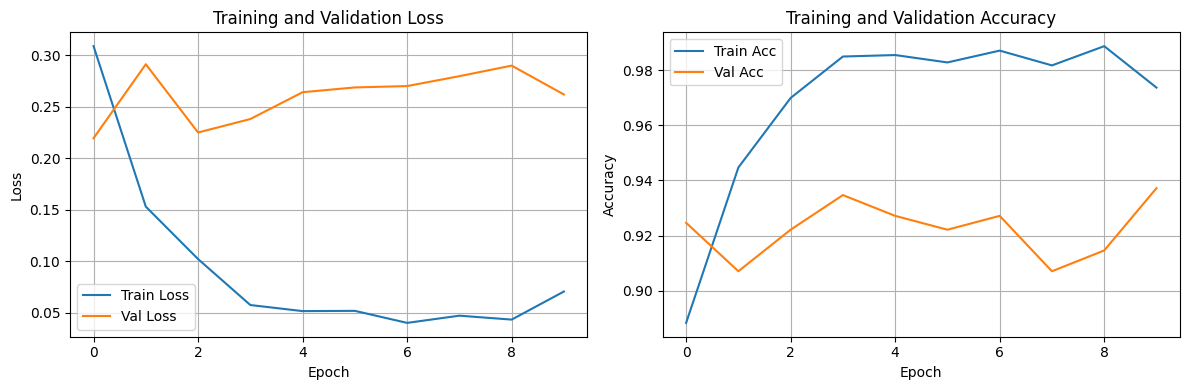

In [12]:
# 学習履歴のプロット
history_save_path = str(OUTPUT_DIR / "history.png")
plot_history(history, save_path=history_save_path)

## 6. Test evaluation

テストデータで最終評価を行います。

- Accuracy
- Precision / Recall / F1（クラス別）
- Confusion Matrix

In [13]:
# 最良モデルの読み込み
model.load_state_dict(torch.load(model_save_path, map_location=device))
print(f"Loaded best model from: {model_save_path}")

Loaded best model from: /Users/HikaruUmada/Library/CloudStorage/OneDrive-筑波大学/授業 2025/ヒューマンコンピュータインタラクション/前半レポート課題/models/best_model.pt


In [14]:
# テストデータで評価
accuracy, report, cm, misclassified_tensors = evaluate_model(
    model=model,
    dataloader=test_loader,
    device=device,
    class_names=class_names
)

print(f"\n" + "="*50)
print("Test Results")
print("="*50)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\nClassification Report:")
print("-"*50)

# クラスごとの結果を表示
for class_name in class_names:
    if class_name in report:
        metrics = report[class_name]
        print(f"\n{class_name}:")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1-Score:  {metrics['f1-score']:.4f}")
        print(f"  Support:   {metrics['support']}")

Evaluating: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]


Test Results

Accuracy: 0.9302 (93.02%)

Classification Report:
--------------------------------------------------

day:
  Precision: 0.9474
  Recall:    0.9130
  F1-Score:  0.9299
  Support:   138.0

night:
  Precision: 0.8843
  Recall:    0.9386
  F1-Score:  0.9106
  Support:   114.0

sunrise_sunset:
  Precision: 0.9524
  Recall:    0.9396
  F1-Score:  0.9459
  Support:   149.0


Confusion matrix saved to /Users/HikaruUmada/Library/CloudStorage/OneDrive-筑波大学/授業 2025/ヒューマンコンピュータインタラクション/前半レポート課題/outputs/confusion_matrix.png


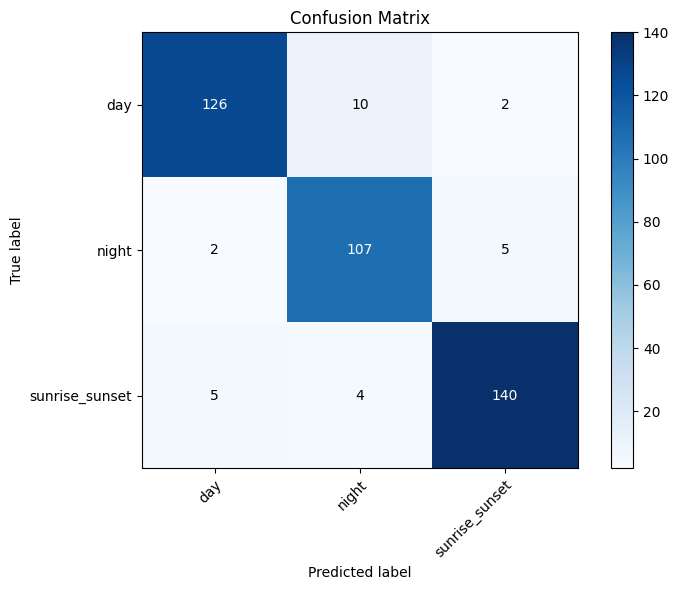

In [15]:
# 混同行列のプロット
cm_save_path = str(OUTPUT_DIR / "confusion_matrix.png")
plot_confusion_matrix(cm, class_names, save_path=cm_save_path)

In [16]:
# 評価メトリクスの保存
config = {
    "model": "ResNet18",
    "pretrained": True,
    "batch_size": BATCH_SIZE,
    "image_size": IMAGE_SIZE,
    "epochs": NUM_EPOCHS,
    "learning_rate": LEARNING_RATE,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "seed": SEED,
    "device": str(device),
}

metrics_save_path = str(OUTPUT_DIR / "metrics.json")
save_metrics(accuracy, report, metrics_save_path, config=config)

Metrics saved to /Users/HikaruUmada/Library/CloudStorage/OneDrive-筑波大学/授業 2025/ヒューマンコンピュータインタラクション/前半レポート課題/outputs/metrics.json


## 7. Visualization（予測例・誤分類例）

誤分類された画像を可視化します。

In [17]:
# 誤分類サンプルの取得（パス付き）
misclassified_samples = get_misclassified_samples_with_paths(
    model=model,
    data_dir=str(DATA_DIR),
    device=device,
    class_names=class_names,
    max_samples=12
)

print(f"Found {len(misclassified_samples)} misclassified samples")

Found 12 misclassified samples


Misclassified examples saved to /Users/HikaruUmada/Library/CloudStorage/OneDrive-筑波大学/授業 2025/ヒューマンコンピュータインタラクション/前半レポート課題/outputs/misclassified_examples.png


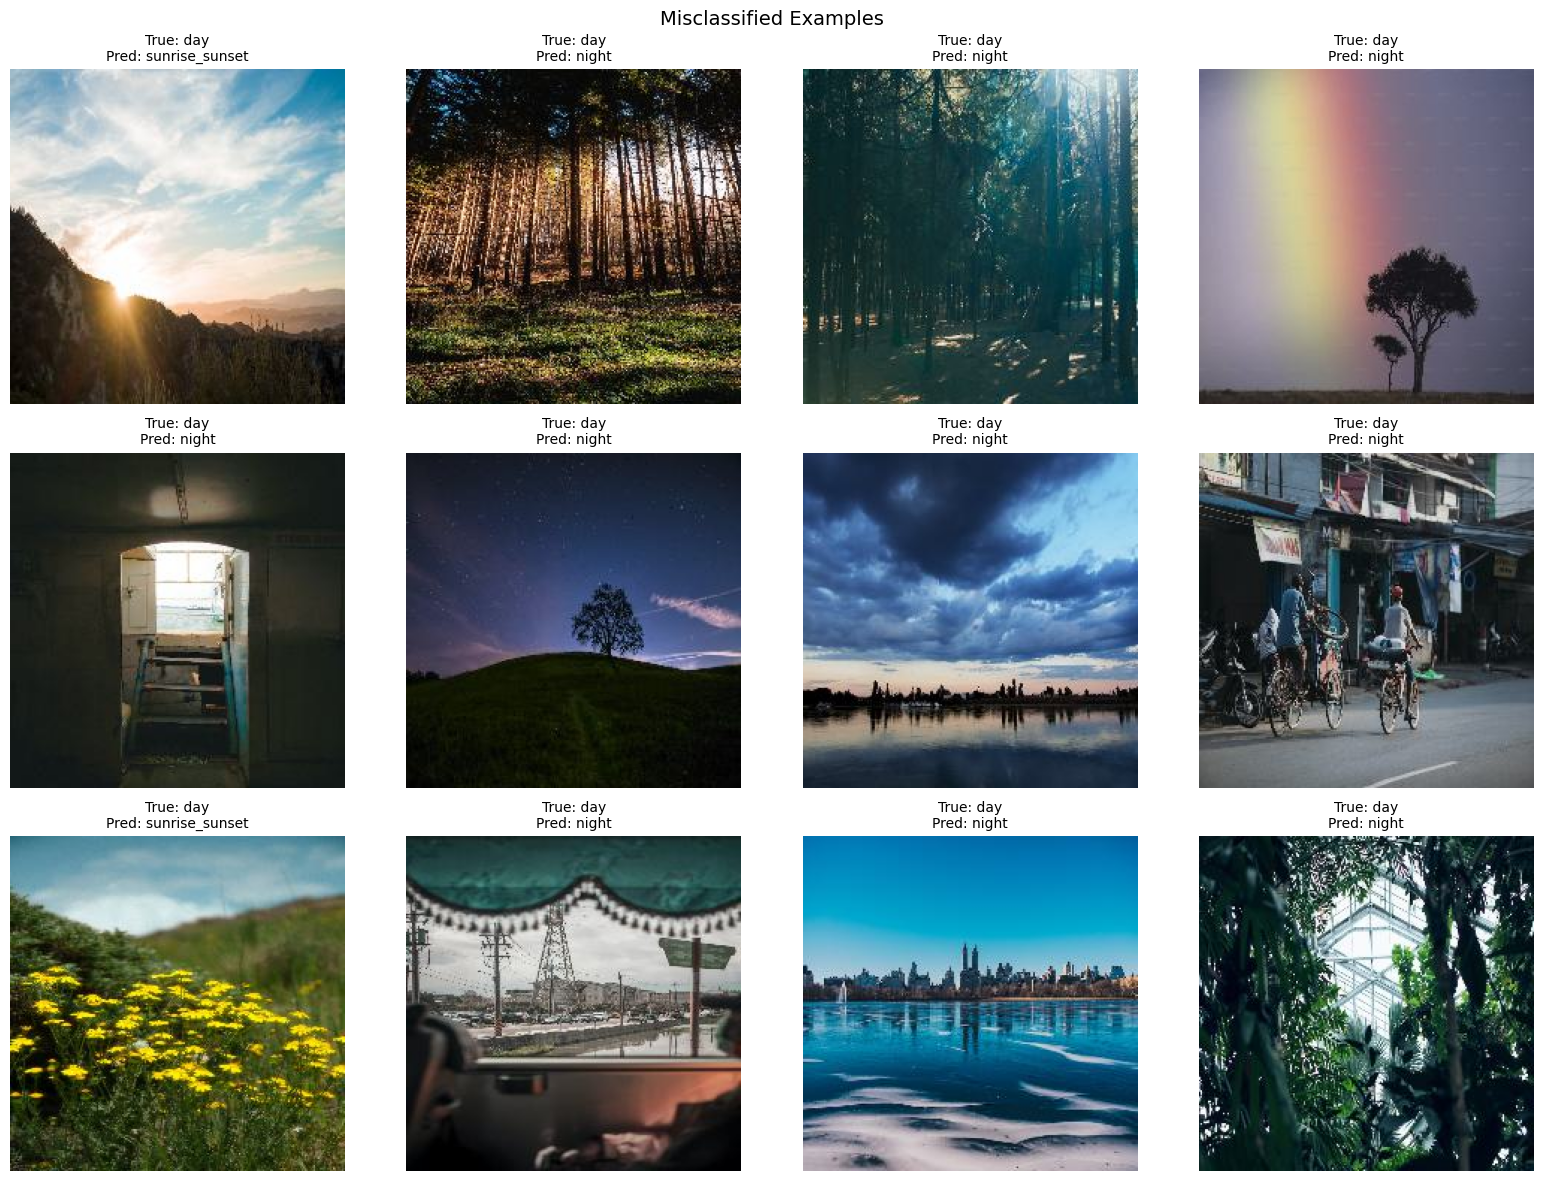

In [18]:
# 誤分類例のプロット
misclassified_save_path = str(OUTPUT_DIR / "misclassified_examples.png")
plot_misclassified_examples(
    misclassified_samples,
    class_names,
    save_path=misclassified_save_path
)

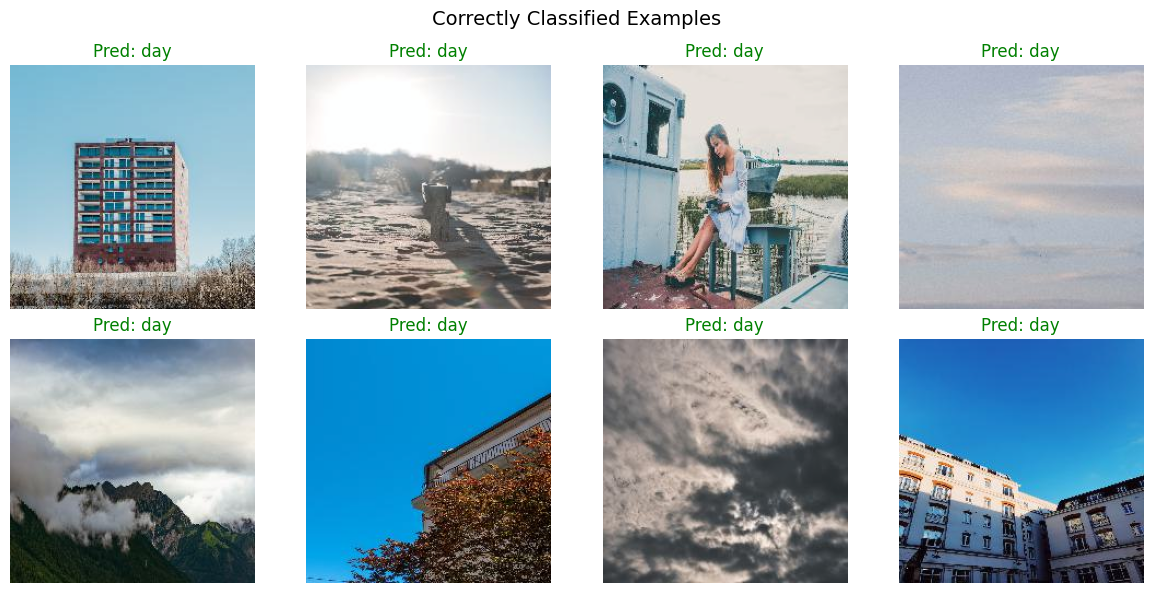

In [19]:
# 正しく分類された例も確認
def show_correct_predictions(model, dataloader, class_names, device, n_samples=8):
    """正しく分類された画像を表示する"""
    model.eval()
    
    correct_samples = []
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(images)):
                if predicted[i] == labels[i]:
                    correct_samples.append((
                        images[i].cpu(),
                        labels[i].item(),
                        predicted[i].item()
                    ))
                    if len(correct_samples) >= n_samples:
                        break
            if len(correct_samples) >= n_samples:
                break
    
    # プロット
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for i, (img_tensor, true_label, pred_label) in enumerate(correct_samples):
        img = img_tensor.numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {class_names[pred_label]}", color="green")
        axes[i].axis("off")
    
    plt.suptitle("Correctly Classified Examples", fontsize=14)
    plt.tight_layout()
    plt.show()

show_correct_predictions(model, test_loader, class_names, device)